# Model evaluation

## pytorch lightning training / validation results

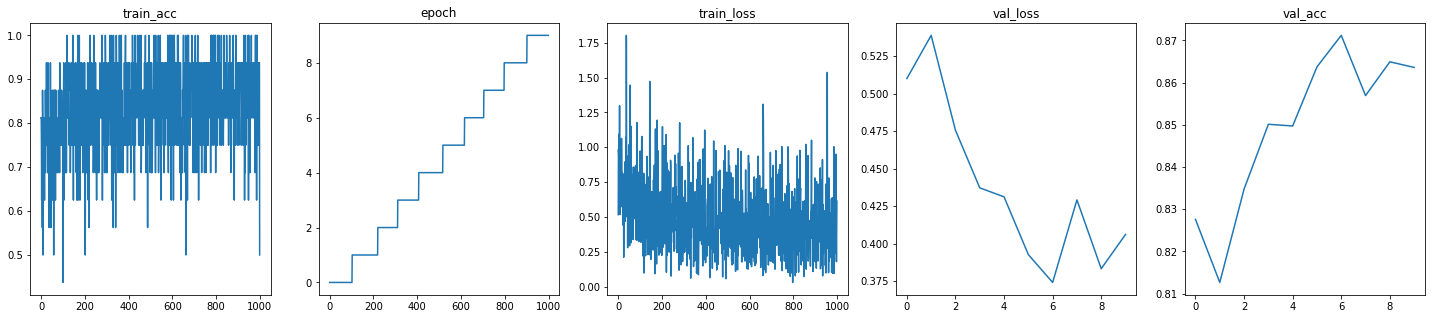

In [1]:
from glob import glob
import json
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 5))
columns = 5
rows = 1
for i, to_read in enumerate(glob("./training-results/*.json")):
    name = to_read.split(".json")[0].split("-")[-1]
    with open(to_read, "r") as stream:
        to_plot = json.load(stream)
    to_plot = [foo[-1] for foo in to_plot]
    fig.add_subplot(rows, columns, i + 1)
    plt.plot(to_plot)
    plt.title(name)

## Run inference on the val / test splits.

Download model from [here](https://github.com/tae898/room-classification/releases/download/v0.1/model.ckpt) and place it in the root repo directory.

In [2]:
image_size = 300
batch_size = 64
num_classes = 7
efficientnet = "efficientnet-b3"
device = "cuda"

from train import RoomDataModule, RoomEfficientNet
from tqdm.notebook import tqdm
import json

with open("./splits.json", "r") as stream:
    splits = json.load(stream)

dm = RoomDataModule(image_size=image_size, batch_size=batch_size)
dm.setup()
net = RoomEfficientNet.load_from_checkpoint(
    checkpoint_path="model.ckpt", num_classes=num_classes, efficientnet=efficientnet
)
net.to(device)
net.eval()
net.freeze()

for split in tqdm(["val", "test"]):
    if split == "val":
        dataloader = dm.val_dataloader
    else:
        dataloader = dm.test_dataloader
    results = []
    for data in tqdm(dataloader()):
        y_hat = net(data["x"].to(device))
        for result_ in y_hat.argmax(dim=1).detach().cpu() == data["y"]:
            results.append(result_.item())
    print(f"{split} accuracy: {sum(results) / len(results)}")

Loaded pretrained weights for efficientnet-b3


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

val accuracy: 0.8712


  0%|          | 0/118 [00:00<?, ?it/s]

test accuracy: 0.8742666666666666


## Run inference on 100 randomly sampled images.

0it [00:00, ?it/s]

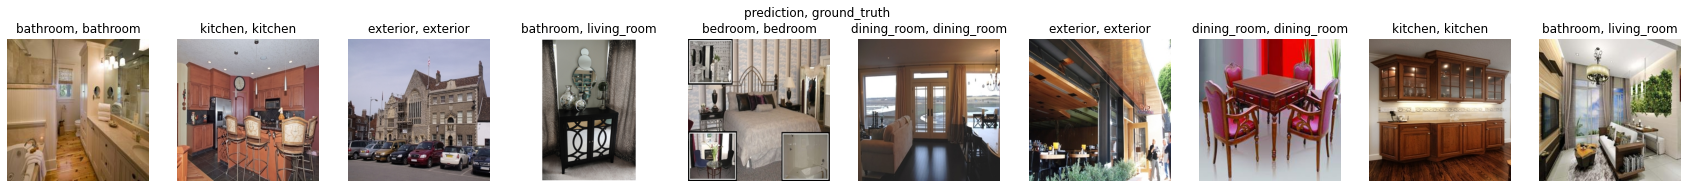

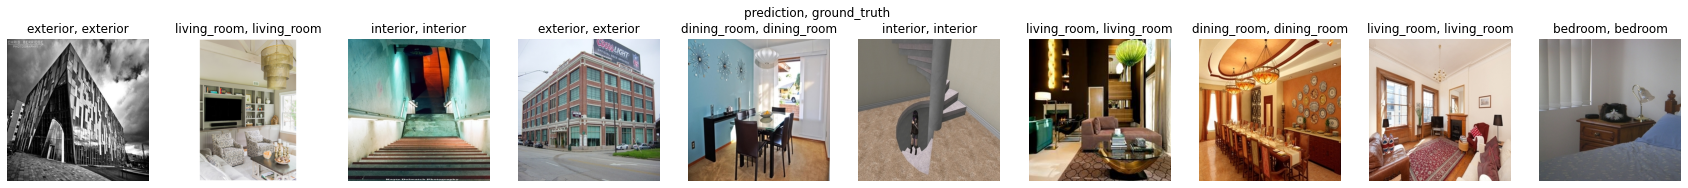

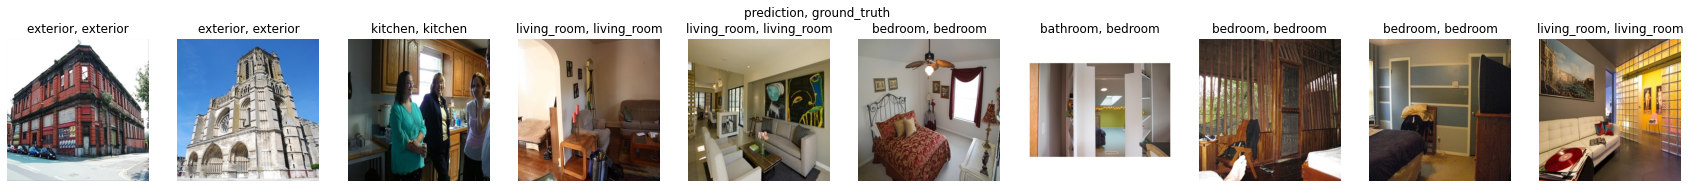

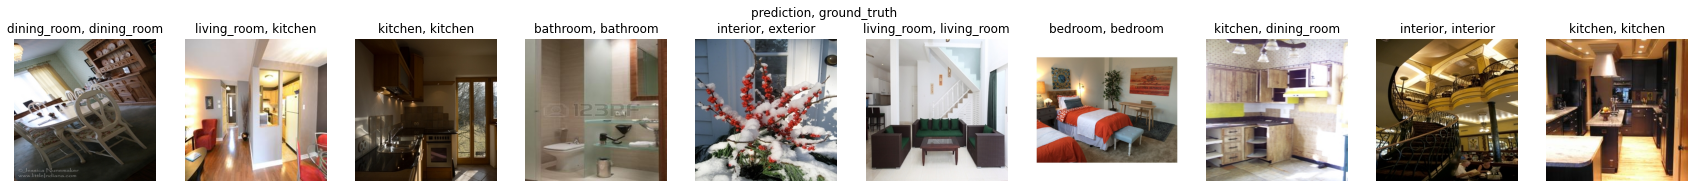

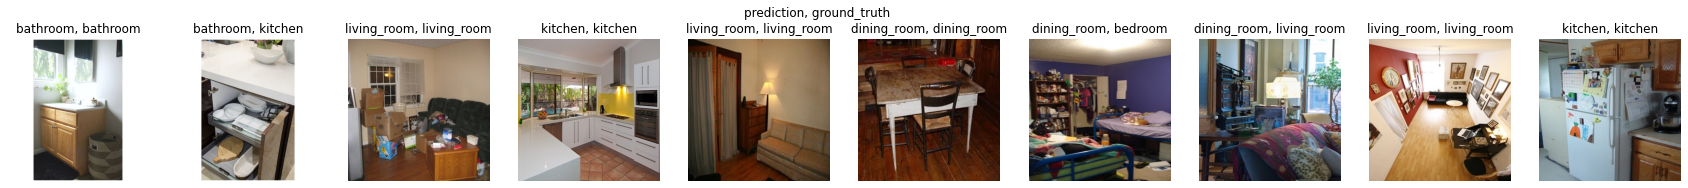

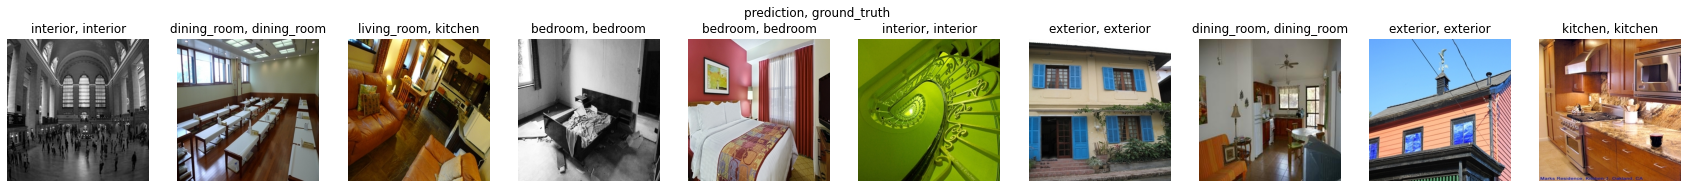

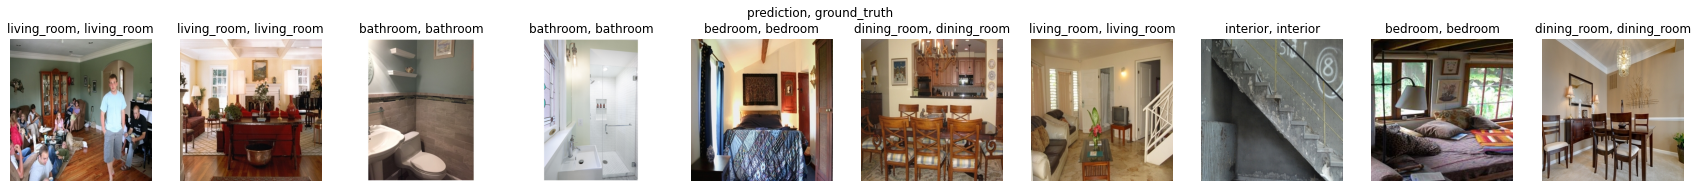

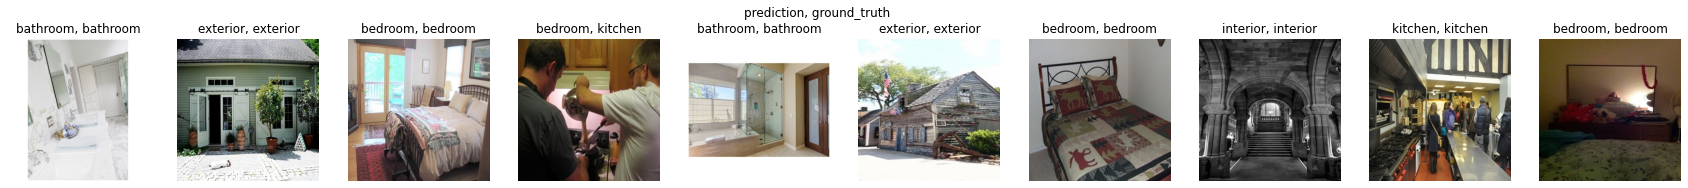

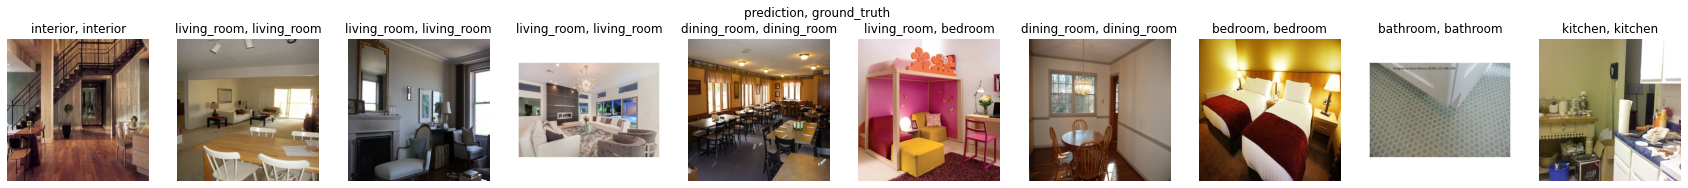

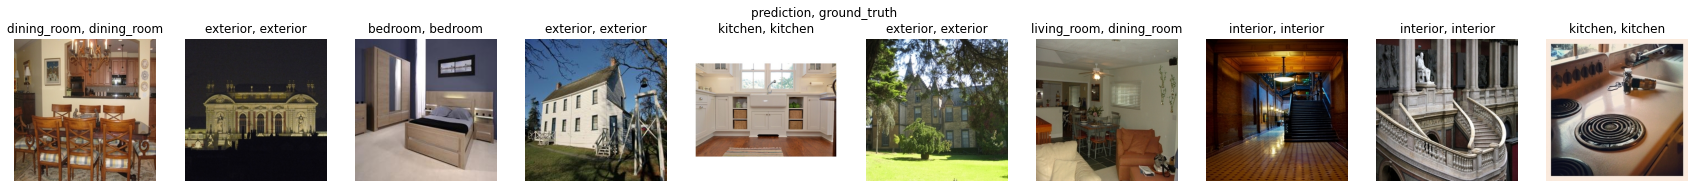

In [3]:
import random
from train import RoomDataset

from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread


def showImagesHorizontally(
    list_of_files: list, titles: list, figsize: tuple = (30, 3), suptitle: str = ""
):
    """https://stackoverflow.com/questions/36006136/how-to-display-images-in-a-row-with-ipython-display"""
    fig = figure(figsize=figsize)
    fig.suptitle(suptitle)
    number_of_files = len(list_of_files)
    assert number_of_files == len(titles)
    for i, title in zip(range(number_of_files), titles):
        a = fig.add_subplot(1, number_of_files, i + 1)
        a.title.set_text(title)
        image = imread(list_of_files[i])
        imshow(image, cmap="Greys_r")
        axis("off")


idx2label = {val: key for key, val in dm.label2idx.items()}


paths = random.choices(splits["test"], k=100)
dataset = RoomDataset(paths=paths, transform=dm.test_transform, label2idx=dm.label2idx)

images = []
titles = []
for path, data in tqdm(zip(paths, dataset)):
    y_hat = net(data["x"].unsqueeze(0).to(device))
    y_hat = y_hat.argmax(dim=1).detach().cpu().item()
    y = data["y"]
    images.append(path)
    titles.append(f"{idx2label[y_hat]}, {idx2label[y]}")

    if len(images) == 10:
        showImagesHorizontally(images, titles, suptitle="prediction, ground_truth")
        del images[:]
        del titles[:]